In [ ]:
%tensorflow_version 2.x
# # !pip install tensorflow-addons==0.6.0
# # !pip install tensorflow-io==0.9.1
# # !pip install efficientnet
!pip install -U git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-pkakkydb
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-pkakkydb
     |████████████████████████████████| 51kB 5.7MB/s 
  Created wheel for efficientnet: filename=efficientnet-1.1.1-cp37-none-any.whl size=18421 sha256=59d4001aa3602f396b05844ba2481ed7e26b5c98aa9a8d2525b83b019039c602
  Stored in directory: /tmp/pip-ephem-wheel-cache-esvj4d4c/wheels/64/60/2e/30ebaa76ed1626e86bfb0cc0579b737fdb7d9ff8cb9522663a
Successfully built efficientnet


In [ ]:
!nvidia-smi

Tue Mar 16 03:29:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 # Import library

In [ ]:
# ライブラリの読み込み

import os
import sys
import random
import shutil
import gc
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import keras
import keras.models as M
import keras.layers as L
import keras.backend as K
import tensorflow as tf

from skimage.io import imread
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras import optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.constraints import max_norm
from keras.applications.imagenet_utils import decode_predictions
from PIL import Image, ImageEnhance, ImageOps
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.xception import Xception
from keras.datasets import cifar100
from efficientnet.keras import EfficientNetB0
from efficientnet.keras import EfficientNetB7
from efficientnet.keras import center_crop_and_resize, preprocess_input
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, GlobalMaxPooling2D, GlobalAveragePooling2D

In [ ]:
# ディレクトリ移動
%cd drive/MyDrive/mokumoku/dataset

/content/drive/MyDrive/mokumoku/dataset


In [ ]:
!ls

 cifar100_submit_TTA_EffNet_dcr0.4_Logloss0.6727629181444228.csv
'Image Recognition_Efn.png'
 inputs
 label_master.tsv
 mymodule
 output
 sample_submit.csv
 submit_001.csv
 submit_002.csv
 submit_003.csv
 submit_004.csv
 submit_005.csv
 submit_TTA_EffNet_dcr0.4_Logloss0.40247903813919744.csv
 test
 test_data.npy
 test.zip
 train
 train_master.tsv
 train.zip
 X_training_data.npy
 X_training_data_sorted.npy
 X_train.npy
 X_valid.npy
 y_training_data.npy
 y_training_data_sorted.npy
 y_train.npy
 y_valid.npy


# Reading Data

In [ ]:
labels = pd.read_csv("train_master.tsv", sep="\t") #教師ラベルの読み込み

In [ ]:
labels.head()

,file_name,label_id
0,train_00000.png,11
1,train_00001.png,15
2,train_00002.png,4
3,train_00003.png,14
4,train_00004.png,1


In [ ]:
master = pd.read_csv("label_master.tsv", sep="\t") #ラベルマスタの読み込み

In [ ]:
master.head()

,label_id,label_name
0,0,aquatic_mammals
1,1,fish
2,2,flowers
3,3,food_containers
4,4,fruit_and_vegetables


In [ ]:
sample = pd.read_csv("sample_submit.csv", header=None, sep=",")

In [ ]:
sample.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,test_00000.png,0.036151,0.014607,0.034591,0.079934,0.053778,0.011690,0.039329,0.079885,0.047027,0.055246,0.062593,0.037947,0.080989,0.066377,0.020849,0.057315,0.056351,0.033405,0.078505,0.053430
1,test_00001.png,0.033393,0.037818,0.021027,0.043661,0.082885,0.041105,0.069309,0.059735,0.023879,0.001008,0.077569,0.053666,0.044468,0.040490,0.090077,0.050215,0.052718,0.067940,0.030642,0.078394
2,test_00002.png,0.098902,0.047091,0.022525,0.059422,0.038273,0.011877,0.086344,0.054882,0.046612,0.050381,0.028493,0.027183,0.092749,0.076549,0.026914,0.099406,0.032409,0.038710,0.000611,0.060666
3,test_00003.png,0.054705,0.080344,0.047048,0.083701,0.043293,0.068830,0.026523,0.076391,0.008649,0.071797,0.020802,0.054486,0.065079,0.060174,0.045692,0.052243,0.006735,0.036344,0.070731,0.026432
4,test_00004.png,0.087472,0.045188,0.091187,0.003265,0.110322,0.102048,0.048273,0.080005,0.050142,0.018821,0.096636,0.038774,0.050342,0.044085,0.057429,0.023512,0.018324,0.002596,0.030469,0.001106


In [ ]:
# X_train = np.load('X_training_data_sorted.npy')

In [ ]:
# Y_train = np.load('y_training_data_sorted.npy')

In [ ]:
# X_test = np.load('test_data.npy')

In [ ]:
Y_train

array([11, 15,  4, ...,  8,  7,  1], dtype=int32)

In [ ]:
(X_train, Y_train), (X_test, Y_test) = cifar100.load_data(label_mode='fine')

169009152/169001437 [==============================] - 6s 0us/step


# Normalization

In [ ]:
# train = X_train / 255
# test = X_test / 255
# randAugument のコードで標準化するため
train = X_train
test = X_test

# Splitting Data

In [ ]:
# Spliting the training data into a training data and a validation data.
val_index_list = []
st = StratifiedShuffleSplit(n_splits = 2, test_size = 0.2, random_state = 1)
for train_index, val_index in st.split(train, Y_train):
    val_index_list.append(val_index)
    X_train_image, X_val_image, y_train_label, y_val_label = train[train_index], train[val_index], Y_train[train_index], Y_train[val_index]
    df_val = labels.iloc[val_index]
print("The number of training data : ", X_train_image.shape[0])
print("The number of validation data : ", X_val_image.shape[0])

The number of training data :  40000
The number of validation data :  10000


In [ ]:
df_val

,file_name,label_id
43035,train_43035.png,3
26211,train_26211.png,1
4522,train_04522.png,5
45187,train_45187.png,5
1148,train_01148.png,0
...,...,...
3999,train_03999.png,14
34320,train_34320.png,4
27970,train_27970.png,10
13354,train_13354.png,19


# Setting Callbacks

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1
)

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1
)

In [ ]:
# ModelCheckpoint
weights_dir='./'
if os.path.exists(weights_dir)==False:os.mkdir(weights_dir)
model_checkpoint = ModelCheckpoint(
    weights_dir + "val_loss{val_loss:.3f}.hdf5",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    period=3
)


# Setting Various Parameters

In [ ]:
batch_size = 32
epochs = 50

steps_per_epoch  = X_train_image.shape[0] // batch_size
validation_steps = X_val_image.shape[0] // batch_size

# Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center = False,
    featurewise_std_normalization = False,
    samplewise_std_normalization = False,
    zca_whitening = False,
    rotation_range = 0,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    vertical_flip = False
)

# Fine Tuning by EfficientNetB0

### （１）Resizing images

In [ ]:
inputs = tf.keras.Input(shape=(None, None, 3))
x = tf.keras.layers.Lambda(lambda img: tf.image.resize(img, (224, 224)))(inputs)
# x = tf.keras.layers.Lambda(EfficientNetB0.)(x)

### （２）Loading the trained model

In [ ]:
# from efficientnet import EfficientNetB0
input_shape = (224, 224, 3)
base_model = EfficientNetB0(
                            input_shape=input_shape,
                            weights='imagenet',
                            include_top=False,
                            drop_connect_rate=0.4, #正則化 defalt値は0.2
                            input_tensor=x)


16809984/16804768 [==============================] - 1s 0us/step


### （３）Rebuild the model

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(rate=0.25)(x)
predictions = Dense(20, activation='softmax')(x)

In [ ]:
# base_model.trainable = False

In [ ]:
# ネットワーク定義
model = Model(inputs = base_model.input, outputs = predictions)

In [ ]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         lambda[0][0]                     
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
______________________________________________________________________________________________

### （４）Training the model

In [ ]:
y_train_categorical = keras.utils.to_categorical(y_train_label)
y_val_categorical = keras.utils.to_categorical(y_val_label)

In [ ]:
y_train_categorical.shape

(40000, 20)

In [ ]:
# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
y_val_label.shape

(10000,)

## RandAugument

In [ ]:
class Rand_Augment():
    def __init__(self, Numbers=None, max_Magnitude=None):
        self.transforms = ['autocontrast', 'equalize', 'rotate', 'solarize', 'color', 'posterize',
                           'contrast', 'brightness', 'sharpness', 'shearX', 'shearY', 'translateX', 'translateY']
        if Numbers is None:
            self.Numbers = len(self.transforms) // 2
        else:
            self.Numbers = Numbers
        if max_Magnitude is None:
            self.max_Magnitude = 10
        else:
            self.max_Magnitude = max_Magnitude
        fillcolor = 128
        self.ranges = {
            # these  Magnitude   range , you  must test  it  yourself , see  what  will happen  after these  operation ,
            # it is no  need to obey  the value  in  autoaugment.py
            "shearX": np.linspace(0, 0.3, 10),
            "shearY": np.linspace(0, 0.3, 10),
            "translateX": np.linspace(0, 0.2, 10),
            "translateY": np.linspace(0, 0.2, 10),
            "rotate": np.linspace(0, 360, 10),
            "color": np.linspace(0.0, 0.9, 10),
            "posterize": np.round(np.linspace(8, 4, 10), 0).astype(np.int),
            "solarize": np.linspace(256, 231, 10),
            "contrast": np.linspace(0.0, 0.5, 10),
            "sharpness": np.linspace(0.0, 0.9, 10),
            "brightness": np.linspace(0.0, 0.3, 10),
            "autocontrast": [0] * 10,
            "equalize": [0] * 10,           
            "invert": [0] * 10
        }
        self.func = {
            "shearX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, magnitude * random.choice([-1, 1]), 0, 0, 1, 0),
                Image.BICUBIC, fill=fillcolor),
            "shearY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, magnitude * random.choice([-1, 1]), 1, 0),
                Image.BICUBIC, fill=fillcolor),
            "translateX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, magnitude * img.size[0] * random.choice([-1, 1]), 0, 1, 0),
                fill=fillcolor),
            "translateY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, 0, 1, magnitude * img.size[1] * random.choice([-1, 1])),
                fill=fillcolor),
            "rotate": lambda img, magnitude: self.rotate_with_fill(img, magnitude),
            # "rotate": lambda img, magnitude: img.rotate(magnitude * random.choice([-1, 1])),
            "color": lambda img, magnitude: ImageEnhance.Color(img).enhance(1 + magnitude * random.choice([-1, 1])),
            "posterize": lambda img, magnitude: ImageOps.posterize(img, magnitude),
            "solarize": lambda img, magnitude: ImageOps.solarize(img, magnitude),
            "contrast": lambda img, magnitude: ImageEnhance.Contrast(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "sharpness": lambda img, magnitude: ImageEnhance.Sharpness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "brightness": lambda img, magnitude: ImageEnhance.Brightness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "autocontrast": lambda img, magnitude: ImageOps.autocontrast(img),
            "equalize": lambda img, magnitude: img,
            "invert": lambda img, magnitude: ImageOps.invert(img)
        }

    def rand_augment(self):
        """Generate a set of distortions.
             Args:
             N: Number of augmentation transformations to apply sequentially. N  is len(transforms)/2  will be best
             M: Max_Magnitude for all the transformations. should be  <= self.max_Magnitude """

        M = np.random.randint(0, self.max_Magnitude, self.Numbers)

        sampled_ops = np.random.choice(self.transforms, self.Numbers)
        return [(op, Magnitude) for (op, Magnitude) in zip(sampled_ops, M)]

    def __call__(self, image):
        operations = self.rand_augment()
        for (op_name, M) in operations:
            operation = self.func[op_name]
            mag = self.ranges[op_name][M]
            image = operation(image, mag)
        return image

    def rotate_with_fill(self, img, magnitude):
        #  I  don't know why  rotate  must change to RGBA , it is  copy  from Autoaugment - pytorch
        rot = img.convert("RGBA").rotate(magnitude)
        return Image.composite(rot, Image.new("RGBA", rot.size, (128,) * 4), rot).convert(img.mode)

    def test_single_operation(self, image, op_name, M=-1):
        '''
        :param image: image
        :param op_name: operation name in   self.transforms
        :param M: -1  stands  for the  max   Magnitude  in  there operation
        :return:
        '''
        operation = self.func[op_name]
        mag = self.ranges[op_name][M]
        image = operation(image, mag)
        return image

In [ ]:
img_augment = Rand_Augment(Numbers=2, max_Magnitude=10)

def get_random_data(x_train_i, y_train_i, data_aug):
    x = array_to_img(x_train_i)

    if data_aug:

        seed_image = img_augment(x)
        seed_image = img_to_array(seed_image)

    else:
        seed_image = x_train_i

    seed_image = seed_image / 255

    return seed_image, y_train_i

def data_generator(x_train, y_train, batch_size, data_aug):
    '''data generator for fit_generator'''
    n = len(x_train)
    i = 0
    while True:
        image_data = []
        label_data = []
        for b in range(batch_size):
            if i==0:
                p = np.random.permutation(len(x_train))
                x_train = x_train[p]
                y_train = y_train[p]
            image, label = get_random_data(x_train[i], y_train[i], data_aug)
            image_data.append(image)
            label_data.append(label)
            i = (i+1) % n
        image_data = np.array(image_data)
        label_data = np.array(label_data)
        yield image_data, label_data

In [ ]:
%%time

hist = model.fit_generator(
                           data_generator(X_train_image, y_train_categorical, batch_size = batch_size, data_aug=True),
                           steps_per_epoch = X_train_image.shape[0] // batch_size,
                           epochs = epochs,
                           validation_data = data_generator(X_val_image, y_val_categorical, batch_size, data_aug = False),
                           validation_steps= X_val_image.shape[0] // batch_size,
                           callbacks = [early_stopping, reduce_lr],
                           shuffle = True,
                           verbose = 1)

# 1250/1250 [==============================] - 270s 216ms/step - loss: 0.5757 - accuracy: 0.8214 - val_loss: 0.7091 - val_accuracy: 0.8140

In [ ]:
def my_eval(model,x,t):
    #model: 評価したいモデル, x: 予測する画像 shape = (batch,32,32,3) t:one-hot表現のlabel
    ev = model.evaluate(x,t)
    print("loss:" ,end = " ")
    print(ev[0])
    print("acc: ", end = "")
    print(ev[1])

my_eval(model,X_val_image/255, y_val_categorical)
# num=2, magnitude=10, loss: 0.8692713975906372

313/313 [==============================] - 8s 22ms/step - loss: 0.4607 - accuracy: 0.8884
loss: 0.46071621775627136
acc: 0.8884000182151794


In [ ]:
predictions = model.predict(test/255)
# [0.9517145752906799, 0.7093999981880188]

In [ ]:
# 予測結果の提出
file_name = sample[0]
df = pd.DataFrame(predictions)
df_concat = pd.concat([file_name, df],axis=1)
# df_concat.to_csv('submit_005.csv',index = False, header=None)

In [ ]:
df_20 =pd.DataFrame()

In [ ]:
# cifar100 から cifar20に戻す

df_20[0] = df[4] + df[30] + df[55] + df[72] + df[95]
df_20[1] = df[1] + df[32] + df[67] + df[73] + df[91]
df_20[2] = df[54] + df[62] + df[70] + df[82] + df[92]
df_20[3] = df[9] + df[10] + df[16] + df[28] + df[61]
df_20[4] = df[0] + df[51] + df[53] + df[57] + df[83]
df_20[5] = df[22] + df[39] + df[40] + df[86] + df[87]
df_20[6] = df[5] + df[20] + df[25] + df[84] + df[94]
df_20[7] = df[6] + df[7] + df[14] + df[18] + df[24]
df_20[8] = df[3] + df[42] + df[43] + df[88] + df[97]
df_20[9] = df[12] + df[17] + df[37] + df[68] + df[76]
df_20[10] = df[23] + df[33] + df[49] + df[60] + df[71]
df_20[11] = df[15] + df[19] + df[21] + df[31] + df[38]
df_20[12] = df[34] + df[63] + df[64] + df[66] + df[75]
df_20[13] = df[26] + df[45] + df[77] + df[79] + df[99]
df_20[14] = df[2] + df[11] + df[35] + df[46] + df[98]
df_20[15] = df[27] + df[29] + df[44] + df[78] + df[93]
df_20[16] = df[36] + df[50] + df[65] + df[74] + df[80]
df_20[17] = df[47] + df[52] + df[56] + df[59] + df[96]
df_20[18] = df[8] + df[13] + df[48] + df[58] + df[90]
df_20[19] = df[41] + df[69] + df[81] + df[85] + df[89]

In [ ]:
df_concat = pd.concat([file_name, df_20],axis=1)
df_concat.to_csv('submit_006.csv',index = False, header=None)

### （５）Evaluating the model

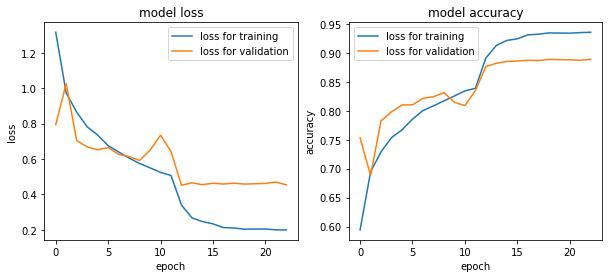

In [ ]:
# ----------------------------------------------
# Some plots
# ----------------------------------------------
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

# loss
def plot_history_loss(fit):
    # Plot the loss in the history
    axL.plot(fit.history['loss'],label="loss for training")
    axL.plot(fit.history['val_loss'],label="loss for validation")
    axL.set_title('model loss')
    axL.set_xlabel('epoch')
    axL.set_ylabel('loss')
    axL.legend(loc='upper right')

# acc
def plot_history_acc(fit):
    # Plot the loss in the history
    axR.plot(fit.history['accuracy'],label="loss for training")
    axR.plot(fit.history['val_accuracy'],label="loss for validation")
    axR.set_title('model accuracy')
    axR.set_xlabel('epoch')
    axR.set_ylabel('accuracy')
    axR.legend(loc='upper left')

plot_history_loss(hist)
plot_history_acc(hist)
plt.show()
fig.savefig('Image Recognition_Efn.png')
plt.close()

In [ ]:
score_Efn = model.evaluate(X_val_image/255, y_val_categorical, verbose=1)
print("evaluate loss: {0[0]}".format(score_Efn))
print("evaluate acc: {0[1]}".format(score_Efn))

313/313 [==============================] - 7s 22ms/step - loss: 0.4607 - accuracy: 0.8884
evaluate loss: 0.46071621775627136
evaluate acc: 0.8884000182151794


In [ ]:
predictions_val_Efn = model.predict(X_val_image/255)
from sklearn.metrics import log_loss
log_loss_Efn = log_loss(y_val_categorical,predictions_val_Efn)
print("EfficinetNetB0_logloss:{0}".format(log_loss_Efn))

EfficinetNetB0_logloss:0.4607161067219758


### （６）Test Time Augmentation with Validation Data

In [ ]:
def tta(model,test_size,generator,batch_size ,epochs = 10):
    #test_time_augmentation
    #batch_sizeは，test_sizeの約数でないといけない．
    pred = np.zeros(shape = (test_size,20), dtype = float)
    step_per_epoch = test_size //batch_size
    for epoch in range(epochs):
        for step in range(step_per_epoch):
            sta = batch_size * step
            end = sta + batch_size
            tmp_x = generator.__next__()
            pred[sta:end] += model.predict(tmp_x)
    return pred / epochs

def tta_generator(test):
    return ImageDataGenerator(rotation_range = 0 , 
                              height_shift_range = 0.1,
                              width_shift_range = 0.1,
                              horizontal_flip = True,
                              vertical_flip = False).flow(test,batch_size = batch_size,shuffle = False)


In [ ]:
batch_size = 20
tta_epochs = 20
tta_pred_Efn = tta(model, X_val_image.shape[0], tta_generator(X_val_image/255), batch_size, epochs = tta_epochs)

TTA_log_loss_Efn = log_loss(y_val_categorical,tta_pred_Efn)

print( accuracy_score( np.argmax(tta_pred_Efn,axis = 1) , np.argmax(y_val_categorical,axis = 1)))
print( "TTA_EfficinetNetB0_logloss:{0}".format(TTA_log_loss_Efn))

0.8787
TTA_EfficinetNetB0_logloss:0.4138309879696729


### （７）Predicting Image Classification

In [ ]:
batch_size = 20
tta_epochs = 50
tta_prediciton_Efn = tta(model,test.shape[0],tta_generator(test/255),batch_size ,epochs = tta_epochs)

In [ ]:
file_name = sample[0]
df = pd.DataFrame(tta_prediciton_Efn)
df_concat = pd.concat([file_name, df],axis=1)
df_concat.head()

,0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,test_00000.png,1.725729e-03,4.749680e-05,4.195087e-05,2.322845e-05,2.029682e-06,1.097612e-03,9.374155e-05,3.749180e-06,7.716825e-05,9.848945e-01,6.383600e-03,2.005344e-05,9.478384e-05,3.965071e-04,7.666991e-04,6.301570e-06,1.270804e-04,2.025308e-03,7.484485e-04,1.424029e-03
1,test_00001.png,2.686098e-03,1.101208e-04,1.843309e-05,5.576760e-02,6.222037e-05,2.886441e-04,5.453349e-03,2.647039e-04,3.428698e-04,1.053813e-03,8.666117e-01,2.391151e-03,1.887236e-04,1.054715e-04,2.455860e-02,4.329851e-05,3.689291e-02,2.898936e-03,3.029862e-05,2.310178e-04
2,test_00002.png,9.998102e-01,2.574067e-06,1.383260e-10,5.298951e-10,1.035667e-08,4.698551e-10,5.079983e-11,1.882859e-07,7.170200e-05,4.546704e-08,1.252949e-08,1.154098e-05,8.254513e-08,9.912720e-09,4.481035e-08,9.661822e-05,6.978453e-06,3.175932e-10,4.000242e-09,5.198148e-09
3,test_00003.png,7.274374e-06,5.118198e-06,3.080354e-06,2.059908e-06,9.983998e-01,7.145071e-06,1.244357e-05,2.175898e-07,2.895137e-06,7.066166e-07,3.166476e-06,1.491344e-03,8.424277e-07,4.047526e-05,1.783816e-06,1.347770e-05,5.949274e-06,6.549682e-07,6.207379e-08,1.485022e-06
4,test_00004.png,8.273549e-08,4.448740e-08,1.102799e-08,4.907933e-09,2.321794e-10,2.817710e-08,1.595786e-08,3.067633e-09,2.937428e-11,1.130087e-06,9.999986e-01,1.046044e-09,3.452016e-11,1.327155e-09,5.124155e-12,1.371969e-09,6.358652e-10,2.723043e-08,1.013762e-10,3.022532e-08


In [ ]:
file_name = sample[0]
df = pd.DataFrame(tta_prediciton_Efn)
df_20 = pd.DataFrame()
df_20[0] = df[4] + df[30] + df[55] + df[72] + df[95]
df_20[1] = df[1] + df[32] + df[67] + df[73] + df[91]
df_20[2] = df[54] + df[62] + df[70] + df[82] + df[92]
df_20[3] = df[9] + df[10] + df[16] + df[28] + df[61]
df_20[4] = df[0] + df[51] + df[53] + df[57] + df[83]
df_20[5] = df[22] + df[39] + df[40] + df[86] + df[87]
df_20[6] = df[5] + df[20] + df[25] + df[84] + df[94]
df_20[7] = df[6] + df[7] + df[14] + df[18] + df[24]
df_20[8] = df[3] + df[42] + df[43] + df[88] + df[97]
df_20[9] = df[12] + df[17] + df[37] + df[68] + df[76]
df_20[10] = df[23] + df[33] + df[49] + df[60] + df[71]
df_20[11] = df[15] + df[19] + df[21] + df[31] + df[38]
df_20[12] = df[34] + df[63] + df[64] + df[66] + df[75]
df_20[13] = df[26] + df[45] + df[77] + df[79] + df[99]
df_20[14] = df[2] + df[11] + df[35] + df[46] + df[98]
df_20[15] = df[27] + df[29] + df[44] + df[78] + df[93]
df_20[16] = df[36] + df[50] + df[65] + df[74] + df[80]
df_20[17] = df[47] + df[52] + df[56] + df[59] + df[96]
df_20[18] = df[8] + df[13] + df[48] + df[58] + df[90]
df_20[19] = df[41] + df[69] + df[81] + df[85] + df[89]
df_concat = pd.concat([file_name, df_20],axis=1)
df_concat.head()

,0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,test_00000.png,0.000206,0.000015,1.904371e-06,5.866552e-06,4.569283e-07,5.795141e-05,0.000020,0.000006,8.947265e-06,0.981252,0.007659,8.538431e-05,5.556657e-06,1.217683e-03,5.504523e-04,1.972036e-05,1.828825e-05,8.629460e-04,7.511835e-03,0.000495
1,test_00001.png,0.001051,0.000068,1.384075e-06,6.190186e-03,3.833902e-05,5.174629e-05,0.000137,0.000063,6.173889e-04,0.000913,0.932016,2.553330e-02,1.317410e-04,2.355802e-04,1.567773e-02,2.107018e-04,8.855804e-03,4.630653e-03,2.930035e-03,0.000647
2,test_00002.png,0.977006,0.000688,7.704558e-08,9.211505e-05,2.990848e-07,5.563595e-07,0.000003,0.000098,2.654359e-04,0.000085,0.000027,7.800155e-04,2.529713e-05,4.111430e-05,9.509150e-05,2.053147e-02,2.273226e-04,4.539907e-06,8.366214e-06,0.000021
3,test_00003.png,0.000003,0.000016,2.571569e-07,5.342176e-07,9.998542e-01,4.045045e-07,0.000024,0.000001,1.884170e-07,0.000005,0.000006,4.342253e-05,8.110077e-07,1.789135e-05,1.358514e-05,5.693835e-06,4.041340e-06,3.613511e-08,3.878413e-07,0.000004
4,test_00004.png,0.000003,0.000019,2.320609e-07,8.187702e-07,5.651622e-07,4.258988e-06,0.000002,0.000001,2.955713e-08,0.000051,0.999897,2.728651e-07,1.423966e-08,8.797532e-07,1.895599e-07,2.068533e-07,1.004619e-07,1.586562e-06,1.831455e-07,0.000018


In [ ]:
df_concat.to_csv('2_10_submit_TTA_EffNet_dcr0.4_Logloss{0}.csv'.format(TTA_log_loss_Efn),index = False, header=None)

In [ ]:
tta_prediciton_Efn = tta(model,X_val_image.shape[0],tta_generator(X_val_image/255),batch_size ,epochs = tta_epochs)

In [ ]:
file_name = df_val
df = pd.DataFrame(tta_prediciton_Efn)
df_concat = pd.concat([df_temp, df],axis=1)
df_concat.head()

In [ ]:
df_temp = df_val.reset_index()

In [ ]:
df_concat = df_concat.drop(columns='index', axis=1)

In [ ]:
# cifar100 から cifar20 に戻す
file_name = sample[0]
df = pd.DataFrame(tta_prediciton_Efn)
df_20 = pd.DataFrame()
df_20[0] = df[4] + df[30] + df[55] + df[72] + df[95]
df_20[1] = df[1] + df[32] + df[67] + df[73] + df[91]
df_20[2] = df[54] + df[62] + df[70] + df[82] + df[92]
df_20[3] = df[9] + df[10] + df[16] + df[28] + df[61]
df_20[4] = df[0] + df[51] + df[53] + df[57] + df[83]
df_20[5] = df[22] + df[39] + df[40] + df[86] + df[87]
df_20[6] = df[5] + df[20] + df[25] + df[84] + df[94]
df_20[7] = df[6] + df[7] + df[14] + df[18] + df[24]
df_20[8] = df[3] + df[42] + df[43] + df[88] + df[97]
df_20[9] = df[12] + df[17] + df[37] + df[68] + df[76]
df_20[10] = df[23] + df[33] + df[49] + df[60] + df[71]
df_20[11] = df[15] + df[19] + df[21] + df[31] + df[38]
df_20[12] = df[34] + df[63] + df[64] + df[66] + df[75]
df_20[13] = df[26] + df[45] + df[77] + df[79] + df[99]
df_20[14] = df[2] + df[11] + df[35] + df[46] + df[98]
df_20[15] = df[27] + df[29] + df[44] + df[78] + df[93]
df_20[16] = df[36] + df[50] + df[65] + df[74] + df[80]
df_20[17] = df[47] + df[52] + df[56] + df[59] + df[96]
df_20[18] = df[8] + df[13] + df[48] + df[58] + df[90]
df_20[19] = df[41] + df[69] + df[81] + df[85] + df[89]
df_concat = pd.concat([file_name, df_20],axis=1)
df_concat.head()

,0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,test_00000.png,2.262952e-06,1.297906e-06,1.154465e-03,4.519355e-02,7.566107e-01,5.673221e-05,2.289295e-04,1.986784e-06,2.852535e-07,1.298907e-06,1.139376e-06,1.188909e-07,2.065708e-07,1.965214e-01,4.051116e-05,2.356756e-05,2.129274e-07,3.762064e-07,0.000017,1.439526e-04
1,test_00001.png,3.380539e-09,1.193693e-08,1.415387e-11,2.612589e-06,4.532675e-10,4.674372e-07,1.876292e-07,1.063581e-09,6.466208e-09,1.602775e-05,1.502623e-08,1.382900e-09,1.424129e-10,2.194498e-08,9.608988e-10,3.468952e-09,4.493644e-10,4.970133e-10,0.959967,4.001375e-02
2,test_00002.png,1.222668e-06,6.198530e-06,4.752267e-08,2.421360e-03,9.029741e-07,9.972679e-01,1.463440e-04,1.273468e-06,2.996891e-07,3.107961e-06,1.743064e-07,6.916989e-07,7.499290e-06,3.084266e-06,1.411623e-06,6.601410e-07,4.154220e-06,8.292242e-08,0.000030,1.035893e-04
3,test_00003.png,8.709531e-01,1.394394e-02,2.091527e-06,3.964914e-05,2.655906e-06,7.864063e-05,2.429846e-04,4.845241e-05,4.348271e-04,5.263814e-04,3.196085e-03,3.922567e-04,2.613626e-04,1.358158e-04,3.302045e-04,1.365560e-03,9.777392e-04,5.561479e-05,0.000051,1.069616e-01
4,test_00004.png,1.911620e-10,5.426358e-11,2.197620e-10,1.362785e-09,2.009341e-09,1.792581e-08,2.478622e-09,4.137164e-12,3.559013e-12,9.385431e-13,9.240698e-13,1.121770e-08,5.898230e-12,1.302088e-10,5.764088e-07,1.368287e-11,7.003469e-12,3.744228e-12,0.999999,1.687316e-10


In [ ]:
df_concat.to_csv('valid_submit_TTA_EffNet_dcr0.4_Logloss{0}.csv'.format(TTA_log_loss_Efn),index = False, header=True)